In [1]:
import numpy as np


from llmize import OPRO
import llmize
import os

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def lp_maximization_problem(x):
    """
    Linear Programming maximization problem with penalty constraints.
    
    Args:
        x (list or numpy array): Decision variables [x1, x2, x3]
    
    Returns:
        float: Penalized objective function value (to be maximized)
    """
    x1, x2, x3 = x
    # Objective Function (Maximize Z)
    Z = 3*x1 + 4*x2 + 6*x3  # No negation since we maximize directly

    # Define a large penalty for constraint violations
    penalty = 0
    large_penalty = -1e2  # Large NEGATIVE penalty (to push infeasible solutions down)

    # Constraints
    if 2*x1 + 3*x2 + x3 > 15:  # Resource 1 constraint
        penalty += large_penalty
    if x1 + 2*x2 + 3*x3 > 20:  # Resource 2 constraint
        penalty += large_penalty
    if 4*x1 + x2 + 2*x3 > 16:  # Resource 3 constraint
        penalty += large_penalty
    if x1 < 0 or x2 < 0 or x3 < 0:  # Non-negativity constraints
        penalty += large_penalty

    return Z + penalty  # Maximize Z while discouraging violations

In [3]:
# Generate random solutions (list of lists) and scores (list of floats)
# Generate initial random solutions
num_samples = 16  # Batch size
num_vars = 3  # Number of decision variables
#round to 2 decimal places
init_samples = [np.round(np.random.uniform(0, 10, num_vars), 2) for _ in range(num_samples)]

# Calculate scores for initial solutions, round to 2 decimal places
init_scores = [np.round(lp_maximization_problem(x), 2) for x in init_samples]

print(init_samples)
print(init_scores)

[array([3.3 , 6.17, 3.87]), array([7.66, 3.14, 8.18]), array([3.75, 7.1 , 0.93]), array([5.59, 0.44, 7.64]), array([3.2 , 7.72, 7.44]), array([7.79, 9.98, 9.67]), array([3.69, 9.3 , 6.29]), array([9.31, 8.37, 7.23]), array([2.5 , 2.01, 4.06]), array([3.24, 6.41, 4.04]), array([0.26, 4.45, 5.99]), array([7.67, 2.24, 2.42]), array([3.97, 0.29, 2.3 ]), array([8.35, 4.79, 1.28]), array([2.31, 2.31, 7.92]), array([7.35, 9.28, 0.08])]
[np.float64(-242.2), np.float64(-215.38), np.float64(-254.77), np.float64(-235.63), np.float64(-214.88), np.float64(-178.69), np.float64(-213.99), np.float64(-195.21), np.float64(-160.1), np.float64(-240.4), np.float64(-245.48), np.float64(-153.51), np.float64(-73.13), np.float64(-248.11), np.float64(-236.31), np.float64(-240.35)]


In [4]:
with open("lp_problem.txt", "r") as f:
    problem_text = f.read()

# Initialize the OPRO optimizer
opro = OPRO(problem_text=problem_text, obj_func=lp_maximization_problem,
            llm_model="gemma-3-27b-it", api_key=os.getenv("GEMINI_API_KEY"))

prompt = opro.get_sample_prompt(init_samples=init_samples, init_scores=init_scores, optimization_type="maximize")
response = opro.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)

Prompt:
Problem: Linear Programming Optimization
-----------------------------------------------------
Objective: Maximize the function
    Z = 3x1 + 4x2 + 6x3

Subject to constraints:
    2x1 + 3x2 + x3 ≤ 15
    x1 + 2x2 + 3x3 ≤ 20
    4x1 + x2 + 2x3 ≤ 16
    x1, x2, x3 ≥ 0

Below are some examples of solutions and their scores:

<sol> 3.3,6.17,3.87 </sol>
score: -242.200

<sol> 7.66,3.14,8.18 </sol>
score: -215.380

<sol> 3.75,7.1,0.93 </sol>
score: -254.770

<sol> 5.59,0.44,7.64 </sol>
score: -235.630

<sol> 3.2,7.72,7.44 </sol>
score: -214.880

<sol> 7.79,9.98,9.67 </sol>
score: -178.690

<sol> 3.69,9.3,6.29 </sol>
score: -213.990

<sol> 9.31,8.37,7.23 </sol>
score: -195.210

<sol> 2.5,2.01,4.06 </sol>
score: -160.100

<sol> 3.24,6.41,4.04 </sol>
score: -240.400

<sol> 0.26,4.45,5.99 </sol>
score: -245.480

<sol> 7.67,2.24,2.42 </sol>
score: -153.510

<sol> 3.97,0.29,2.3 </sol>
score: -73.130

<sol> 8.35,4.79,1.28 </sol>
score: -248.110

<sol> 2.31,2.31,7.92 </sol>
score: -236.310


In [ ]:
from llmize.callbacks import EarlyStopping, AdaptTempOnPlateau, OptimalScoreStopping

# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='best_score', min_delta=0.001, patience=5, verbose=1)

# Define the optimal score stopping callback
optimal_score_callback = OptimalScoreStopping(optimal_score=41.08, tolerance=0.01)

# Define the temperature adaptation callback
adapt_temp_callback = AdaptTempOnPlateau(monitor='best_score', init_temperature=1.0, min_delta=0.001, patience=2, factor=1.1, max_temperature=1.9, verbose=1)

callbacks = [earlystop_callback, optimal_score_callback, adapt_temp_callback]

In [6]:
results = opro.maximize(init_samples=init_samples, init_scores=init_scores, num_steps=250, batch_size=16, callbacks=callbacks)


Running OPRO optimization with 250 steps and batch size 16...
Step 0 - Best Initial Score: -73.130, Average Initial Score: -209.259
Step 1 - Current Best Score: 37.000, Average Batch Score: -116.513 - Best Batch Score: 37.000
No improvement in best_score. Patience count: 1/5
Step 2 - Current Best Score: 40.200, Average Batch Score: -119.550 - Best Batch Score: 40.200
Step 3 - Current Best Score: 40.200, Average Batch Score: -5.938 - Best Batch Score: 39.500
No improvement in best_score. Patience count: 1/5
Step 4 - Current Best Score: 40.200, Average Batch Score: 6.555 - Best Batch Score: 39.500
No improvement in best_score. Patience count: 2/5
Step 5 - Current Best Score: 40.400, Average Batch Score: -30.325 - Best Batch Score: 40.400
Step 6 - Current Best Score: 40.800, Average Batch Score: -30.269 - Best Batch Score: 40.800
Step 7 - Current Best Score: 40.800, Average Batch Score: -30.317 - Best Batch Score: 40.500
No improvement in best_score. Patience count: 1/5
Step 8 - Current B

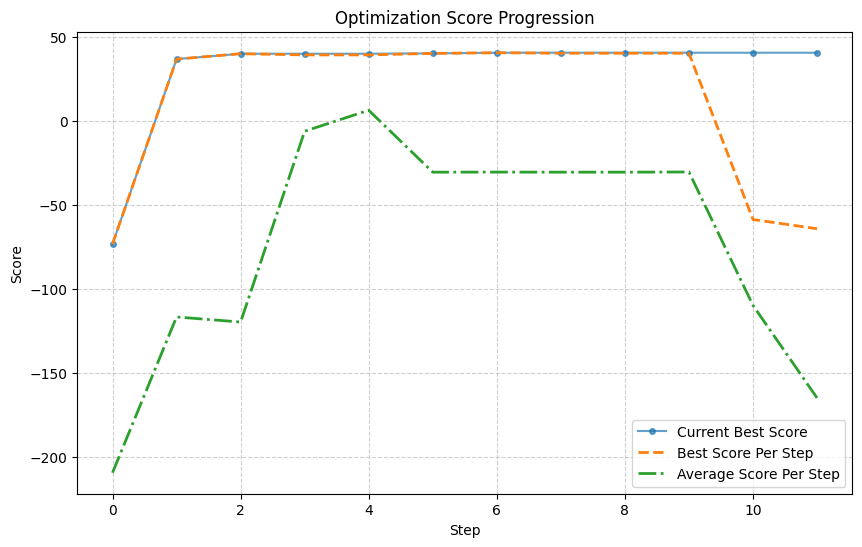

In [7]:
# add plotting here
from llmize.utils.plotting import plot_scores
plot_scores(results)
